In [1]:
from support import *
import numpy as np
import operator
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from itertools import product

Data loader.

In [2]:
data = load_dataset('dataset_a1.txt')

These cells define the problem, some of the toolbox settings are changed in the gridsearch function but these cells define the toolbox for the first time.

In [3]:
creator.create("Fitness", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.Fitness)

In [4]:
toolbox = base.Toolbox()
# Attribute generator 
toolbox.register("attr_bool", random.randint, -1, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 144)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [5]:
toolbox.register('evaluate',fitness)
toolbox.register('mate',tools.cxTwoPoint)
toolbox.register('mutate',tools.mutFlipBit, indpb = 0.05 )
toolbox.register('select', tools.selRoulette)

The main function for obtaining the best individuals and statistics.

In [35]:
def main(ngen,mu,cxpb,mutpb):

    pop = toolbox.population(n=mu)
    hof = tools.ParetoFront()

    # The hall of fame contains the best individual that ever lived in the population during the evolution
    # a ParetoFront may be used to retrieve the best non dominated individuals of the evolution
    # a Statistics object is created for compiling four different statistics (avg, std, min, max) over the generations.

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    # parameter Statistics 1 function ast- A function to access the values on which to compute the statistics, 
    # ind is argument of function and (ind.fitness.values) is the expression that is evaluated and the result of the expression is returned
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0) #standard deviation,  dispersion of a dataset relative to its mean and
    #is calculated as the square root of the variance.
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)
    best_of_gens=[]

    population, logbook = algorithms.eaSimple(pop, toolbox, cxpb, mutpb, ngen, stats, halloffame=hof,verbose=False)
    best = [logbook[gen]['max'] for gen in range(len(logbook))] # Stores the best individuals fitness for each generation

    return logbook, best, hof

Main gridsearch function that tries all different hyperparameters for the following exercises.

In [36]:
def gridsearch(mate_methods, mutation_methods, select_methods, ngen, mu, cxpb_list, mutpb_list, nruns=30):
    '''
    Function for running the GA with a range of different settings

    attrs:
        mate_methods (list): list containing the different methods to use for mating
        mutation_methods (list): list containing the different methods to use for mutating
        select_methods (list): list containing the different methods to use for selecting
        ngen (int): amount of generations for each run of the GA
        mu (int): population size of the GA
        cxpb_list (list): list with the different crossover probabilities
        mutpb_list (list): list with the different mutation probabilities
        nruns (int): amount of runs you want to perform for each combination of settings, default = 30
    '''
    # Creating a dict of the different methods
    dictionary = {'mate': mate_methods, 'mutate':mutation_methods, 'select': select_methods,  'cxpb': cxpb_list, 'mutpb': mutpb_list} 
    # Creating a list of dictionaries, with all different combinations taken from the above dictionary
    keys, values = zip(*dictionary.items())
    iter_dict = [dict(zip(keys,p) )for p in product(*values)]
    # Empty list for storing the different configs and the ABF at each generation
    config = []
    means_per_config = []
    # Loop over all configs
    for method_id, method in enumerate(iter_dict):
        # Setting the parameters for each config                            
        toolbox.register('evaluate',fitness)
        toolbox.register('mate',method['mate'])
        toolbox.register('mutate',method['mutate'], indpb = 0.05)
        if method['select'] == tools.selTournament:
            toolbox.register('select', tools.selTournament, tournsize = 2)
        else:
            toolbox.register('select', method['select'])


        # Creating a new list for storing means and best fitnesses
        best_fitness_list = []
        best_per_run = []

        # Store start time to evaluate how long each method takes
        start = time.time()

        
        for i in range(nruns):
            logbook, best, hof = main(ngen,mu,method['cxpb'],method['mutpb'])
            best_fitness_list.append(best)
            best_per_run.append(max(best))

        # Storing the best value of each run and the mean best fitness for each generation
        best_per_run = np.array(best_per_run)
        best_array = np.array(best_fitness_list)[:,:,0]
        means = np.mean(best_array,axis = 0)

        # End time
        end = time.time()

        # Storing the current config and how long it took to complete
        config.append({'mating': [method['mate'].__name__,method['cxpb']],'mutation':[method['mutate'].__name__,method['mutpb']],\
                       'selection':method['select'].__name__, 'time': int(end-start)})

        # Collecting the pest runs and the means per config in an output matrix
        if method_id == 0: # First iteration we create the matrix, other iterations we concatenate to it
            means_per_config = means[:,None]
            best_per_run_per_config = best_per_run[:None]
        else:
            means_per_config=np.concatenate((means_per_config,means[:,None]),axis = 1)  
            best_per_run_per_config = np.concatenate((best_per_run_per_config,best_per_run[:None]),axis = 1)

        print('Config {}/{}'.format(method_id+1,len(iter_dict)))

    return means_per_config,best_per_run_per_config,config

### Exercise 1

In [24]:
mate_methods = [tools.cxTwoPoint]
mutation_methods =[tools.mutFlipBit]
select_methods= [tools.selTournament]
cxpb = [0.2]
mutpb = [0.2]
ngen = 100
mu = 50
abf,best_individuals,config = gridsearch(mate_methods,mutation_methods,select_methods,ngen,mu,cxpb,mutpb,nruns = 1)


Config 1/1


<Figure size 640x480 with 0 Axes>

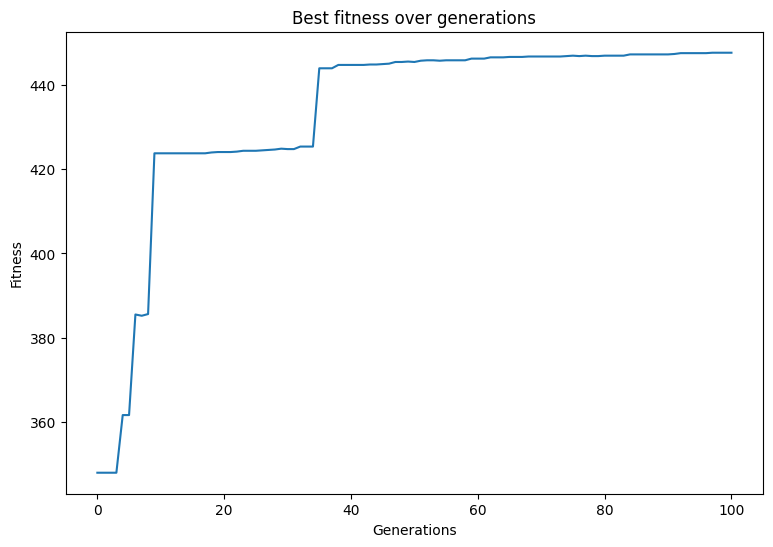

In [25]:
# Plot both the figure and the legend separately
plt.figure()
fig, axes = plt.subplots(ncols=1,nrows=1,figsize=(9,6))
for i in range(abf.shape[1]):
    axes.plot(abf[:,i],label=f"Configuration {i+1}")
h,l = axes.get_legend_handles_labels()
axes.set_xlabel('Generations')
axes.set_ylabel('Fitness')
axes.set_title('Best fitness over generations');

In [ ]:
plt.boxplot(best_individuals);
plt.xlabel('Configurations')
plt.ylabel('Fitness of best individual')
plt.title('Boxplot of fitness of best individuals for each configuration')

### Exercise 2

In [10]:
mate_methods = [tools.cxTwoPoint,tools.cxOrdered]
mutation_methods =[tools.mutFlipBit,tools.mutShuffleIndexes]
select_methods= [tools.selRoulette, tools.selTournament]
cxpb = [0.2]
mutpb = [0.2]
ngen = 100
mu = 50
abf,best_individuals,config = gridsearch(mate_methods,mutation_methods,select_methods,ngen,mu,cxpb,mutpb)

Config 1/8
Config 2/8
Config 3/8
Config 4/8
Config 5/8
Config 6/8
Config 7/8
Config 8/8


Display settings and results exercise 2.

In [ ]:
# Plot both the figure and the legend separately
plt.figure()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(18,6))
for i in range(abf.shape[1]):
    axes[0].plot(abf[:,i],label=f"Configuration {i+1}")
h,l = axes[0].get_legend_handles_labels()
axes[0].set_xlabel('Generations')
axes[0].set_ylabel('ABF')
axes[0].set_title('Average best fitness over generations')
if len(config)>10: axes[1].legend(h,l,loc='center',prop={'size':15})
else: axes[1].legend(h,l,loc='center',prop={'size':25})
axes[1].axis('off');

In [ ]:
plt.boxplot(best_individuals);
plt.xlabel('Configurations')
plt.ylabel('Fitness of best individual')
plt.title('Boxplot of fitness of best individuals for each configuration')

In [13]:
pd_data2 = pd.DataFrame(config)
pd_data2['ABF'] = np.max(abf,axis=0)

pd_data2[['crossover', 'p_crossover']] = pd_data2['mating'].apply(lambda x: pd.Series([x[0], x[1]]))
pd_data2[['mutation', 'p_mutation']] = pd_data2['mutation'].apply(lambda x: pd.Series([x[0], x[1]]))
pd_data2['configuration'] = list(range(1,len(config)+1))

pd_ex2 = pd_data2[['configuration','crossover','p_crossover','mutation','p_mutation','selection','ABF','time']]
pd.set_option('display.expand_frame_repr', False)

# print(pd_ex2)
print(pd_ex2.to_latex(index=False, float_format="{:0.2f}".format))

\begin{tabular}{rlrlrlrr}
\toprule
configuration & crossover & p_crossover & mutation & p_mutation & selection & ABF & time \\
\midrule
1 & cxTwoPoint & 0.20 & mutFlipBit & 0.20 & selRoulette & 404.98 & 49 \\
2 & cxTwoPoint & 0.20 & mutFlipBit & 0.20 & selTournament & 421.06 & 47 \\
3 & cxTwoPoint & 0.20 & mutShuffleIndexes & 0.20 & selRoulette & 457.70 & 46 \\
4 & cxTwoPoint & 0.20 & mutShuffleIndexes & 0.20 & selTournament & 471.92 & 48 \\
5 & cxOrdered & 0.20 & mutFlipBit & 0.20 & selRoulette & 381.08 & 44 \\
6 & cxOrdered & 0.20 & mutFlipBit & 0.20 & selTournament & 412.89 & 46 \\
7 & cxOrdered & 0.20 & mutShuffleIndexes & 0.20 & selRoulette & 446.18 & 46 \\
8 & cxOrdered & 0.20 & mutShuffleIndexes & 0.20 & selTournament & 461.77 & 52 \\
\bottomrule
\end{tabular}



### Exercise 3

In [14]:
mate_methods = [tools.cxOrdered]
mutation_methods = [tools.mutShuffleIndexes]
select_methods = [tools.selTournament]
cxpb = [0.2, 0.4, 0.6, 0.8]
mutpb = [0.2, 0.4, 0.6, 0.8]
ngen = 100
mu = 50
abf,best_individuals,config = gridsearch(mate_methods,mutation_methods,select_methods,ngen,mu,cxpb,mutpb)

Config 1/16
Config 2/16
Config 3/16
Config 4/16
Config 5/16
Config 6/16
Config 7/16
Config 8/16
Config 9/16
Config 10/16
Config 11/16
Config 12/16
Config 13/16
Config 14/16
Config 15/16
Config 16/16


Display settings and results exercise 3.

<Figure size 640x480 with 0 Axes>

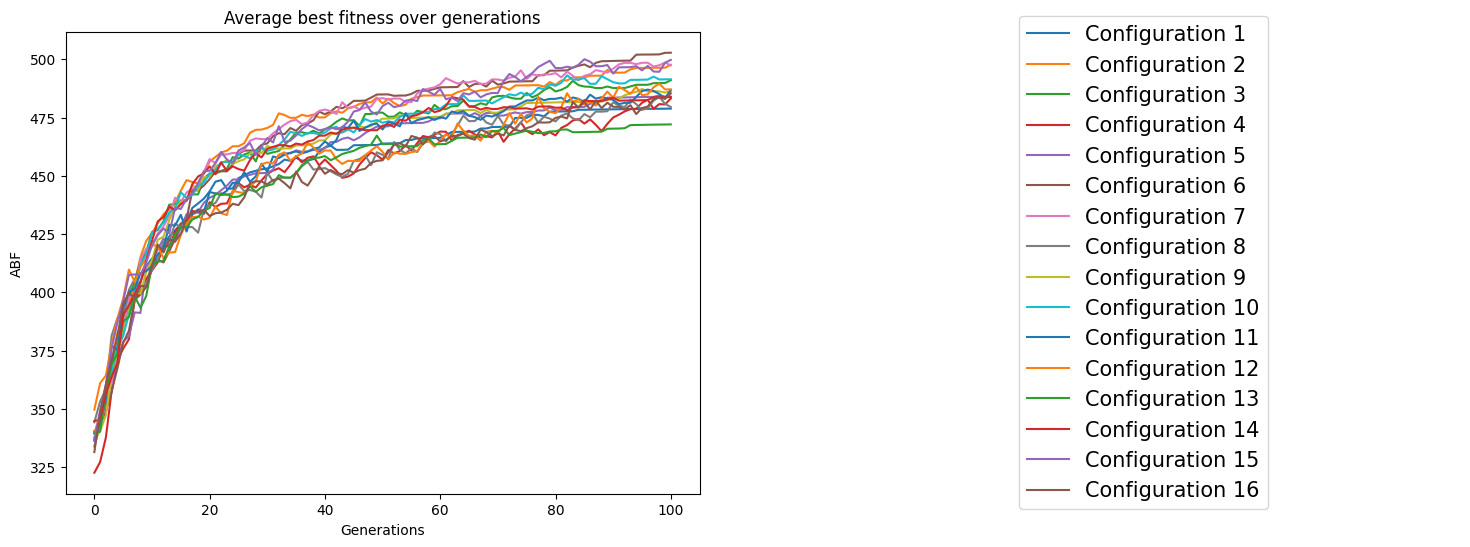

In [15]:
# Plot both the figure and the legend separately
plt.figure()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(18,6))
for i in range(abf.shape[1]):
    axes[0].plot(abf[:,i],label=f"Configuration {i+1}")
h,l = axes[0].get_legend_handles_labels()
axes[0].set_xlabel('Generations')
axes[0].set_ylabel('ABF')
axes[0].set_title('Average best fitness over generations')
if len(config)>10: axes[1].legend(h,l,loc='center',prop={'size':15})
else: axes[1].legend(h,l,loc='center',prop={'size':25})
axes[1].axis('off');

Text(0.5, 1.0, 'Boxplot of fitness of best individuals for each configuration')

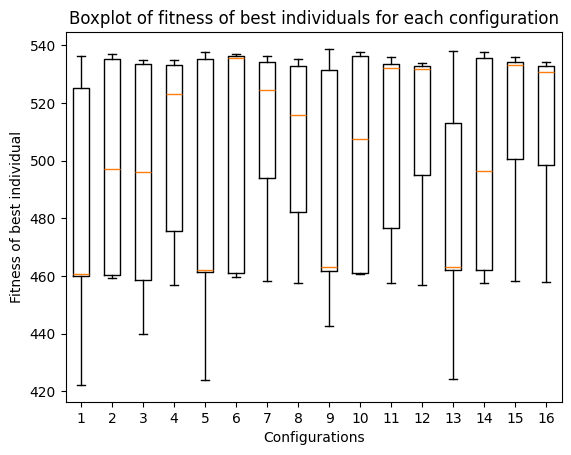

In [16]:
plt.boxplot(best_individuals);
plt.xlabel('Configurations')
plt.ylabel('Fitness of best individual')
plt.title('Boxplot of fitness of best individuals for each configuration')

In [18]:
pd_data3 = pd.DataFrame(config)
pd_data3['ABF'] = np.max(abf,axis=0)

pd_data3[['crossover', 'p_crossover']] = pd_data3['mating'].apply(lambda x: pd.Series([x[0], x[1]]))
pd_data3[['mutation', 'p_mutation']] = pd_data3['mutation'].apply(lambda x: pd.Series([x[0], x[1]]))
pd_data3['configuration'] = list(range(1,len(config)+1))

pd_ex3 = pd_data3[['p_crossover','p_mutation','ABF']]
pd.set_option('display.float_format', '{:.2f}'.format)

# print(pd_ex3)
print(pd_ex3.to_latex(index=False, float_format="{:0.2f}".format))

    p_crossover  p_mutation    ABF
0          0.20        0.20 478.82
1          0.20        0.40 497.64
2          0.20        0.60 490.99
3          0.20        0.80 483.14
4          0.40        0.20 484.47
5          0.40        0.40 502.79
6          0.40        0.60 498.57
7          0.40        0.80 483.91
8          0.60        0.20 487.24
9          0.60        0.40 493.11
10         0.60        0.60 486.98
11         0.60        0.80 489.53
12         0.80        0.20 472.04
13         0.80        0.40 483.76
14         0.80        0.60 500.01
15         0.80        0.80 485.40


### Exercise 4

Define the decorator.

In [198]:
def max_entries(max_nonzero):
    def decorator(func):
        def wrapper(*args,**kargs):
            offspring = func(*args,**kargs)
            # modified_offspring=[]
            for child in offspring:
                # child = list_to_array(child)
                for column in range(12):
                    column_non_zeros= [] # list to save indexes for non zero elements of a column
                    for row in range(12):
                        index = row*12+column
                        if child[index]!=0:
                            column_non_zeros.append([index, child[index]]) #save non zero elements for the current column

                    if len(column_non_zeros) > max_nonzero: # if there are more than max non zero value choose randomly from them
                        for row in range(12):
                            index = row*12+column
                            child[index]=0 # transform all column values to zero 
                        choices=np.random.choice(len(column_non_zeros), size=max_nonzero, replace=False) # pick max number of non zero values at random
                        for pick in choices:
                            child[column_non_zeros[pick][0]]=column_non_zeros[pick][1]
            return offspring
        return wrapper
    return decorator

### Exercise 5

Petri net without decorator.

In [220]:
max_nonzero = 2

toolbox = base.Toolbox()
# Attribute generator 
toolbox.register("attr_bool", random.randint, -1, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 144)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register('select', tools.selTournament,tournsize = 2)
toolbox.register('evaluate',fitness)

toolbox.register('mate',tools.cxOrdered)
toolbox.register('mutate',tools.mutShuffleIndexes, indpb = 0.05 )
pcros = 0.6
pmut = 0.8
logbook, best_ind, hof = main(ngen,mu,pcros,pmut)

Plot the Petri net without the decorator.

In [222]:
matrix_to_graphviz(hof[0], output_file="output.pdf")

Petri net with decorator.

In [ ]:
max_nonzero = 2

toolbox = base.Toolbox()
# Attribute generator 
toolbox.register("attr_bool", random.randint, -1, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 144)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register('select', tools.selTournament,tournsize = 2)
toolbox.register('evaluate',fitness)

toolbox.register('mate',tools.cxOrdered)
toolbox.register('mutate',tools.mutShuffleIndexes, indpb = 0.05)

toolbox.decorate("mate", max_entries(max_nonzero))
toolbox.decorate("mutate", max_entries(max_nonzero))
pcros = 0.6
pmut = 0.8
logbook2, best_ind_sparse, hof2 = main(ngen,mu,pcros,pmut)

Plot the Petri net without the decorator.

In [ ]:
matrix_to_graphviz(hof2[0], output_file="output_sparse.pdf")